In [39]:
import os
import glob
import numpy as np
import nibabel as nib
import utils
import image_utils
from skimage import transform

def crop_or_pad_slice_to_size(slice, nx, ny):
    x, y = slice.shape
    x_s = (x - nx) // 2
    y_s = (y - ny) // 2
    x_c = (nx - x) // 2
    y_c = (ny - y) // 2

    if x > nx and y > ny:
        slice_cropped = slice[x_s:x_s + nx, y_s:y_s + ny]
    else:
        slice_cropped = np.zeros((nx, ny))
        if x <= nx and y > ny:
            slice_cropped[x_c:x_c + x, :] = slice[:, y_s:y_s + ny]
        elif x > nx and y <= ny:
            slice_cropped[:, y_c:y_c + y] = slice[x_s:x_s + nx, :]
        else:
            slice_cropped[x_c:x_c + x, y_c:y_c + y] = slice[:, :]

    return slice_cropped


diag_list = {'test': [], 'train': []}
height_list = {'test': [], 'train': []}
weight_list = {'test': [], 'train': []}
patient_id_list = {'test': [], 'train': []}
cardiac_phase_list = {'test': [], 'train': []}

file_list = {'test': [], 'train': []}
num_slices = {'test': 0, 'train': 0}

mode = '2D'
diagnosis_dict = {'NOR': 0, 'MINF': 1, 'DCM': 2, 'HCM': 3, 'RV': 4}

input_folder = "/home/sadegh/acdc_segmenter/training"

for folder in os.listdir(input_folder):

    folder_path = os.path.join(input_folder, folder)

    if os.path.isdir(folder_path):

        train_test = 'train'

        infos = {}
        for line in open(os.path.join(folder_path, 'Info.cfg')):
            label, value = line.split(':')
            infos[label] = value.rstrip('\n').lstrip(' ')

        patient_id = folder.lstrip('patient')

        for file in glob.glob(os.path.join(folder_path, 'patient???_frame??.nii.gz')):

            file_list[train_test].append(file)

            # diag_list[train_test].append(diagnosis_to_int(infos['Group']))
            diag_list[train_test].append(diagnosis_dict[infos['Group']])
            weight_list[train_test].append(infos['Weight'])
            height_list[train_test].append(infos['Height'])

            patient_id_list[train_test].append(patient_id)

            systole_frame = int(infos['ES'])
            diastole_frame = int(infos['ED'])

            file_base = file.split('.')[0]
            frame = int(file_base.split('frame')[-1])
            if frame == systole_frame:
                cardiac_phase_list[train_test].append(1)  # 1 == systole
            elif frame == diastole_frame:
                cardiac_phase_list[train_test].append(2)  # 2 == diastole
            else:
                cardiac_phase_list[train_test].append(0)  # 0 means other phase

            nifty_img = nib.load(file)
            num_slices[train_test] += nifty_img.shape[2]

diagnosis = np.asarray(diag_list['train'], dtype=np.uint8)
weight = np.asarray(weight_list['train'], dtype=np.float32)
height = np.asarray(height_list['train'], dtype=np.float32)
patient_id = np.asarray(patient_id_list['train'], dtype=np.uint8)
cardiac_phase = np.asarray(cardiac_phase_list['train'], dtype=np.uint8)

size = (212,212)
nx, ny = size
target_resolution = (1.36719, 1.36719)
n_test = num_slices['test']
n_train = num_slices['train']

mask_list = {'test': [], 'train': [] }
img_list = {'test': [], 'train': [] }

for train_test in ['train']:

    for file in file_list[train_test]:

        file_base = file.split('.nii.gz')[0]
        file_mask = file_base + '_gt.nii.gz'

        img_dat = utils.load_nii(file)
        mask_dat = utils.load_nii(file_mask)

        img = img_dat[0].copy()
        mask = mask_dat[0].copy()

        img = image_utils.normalise_image(img)

        pixel_size = (img_dat[2].structarr['pixdim'][1],
                      img_dat[2].structarr['pixdim'][2],
                      img_dat[2].structarr['pixdim'][3])
        
        scale_vector = [pixel_size[0] / target_resolution[0], pixel_size[1] / target_resolution[1]]

        for zz in range(img.shape[2]):

            slice_img = np.squeeze(img[:, :, zz])
            slice_rescaled = transform.rescale(slice_img,
                                               scale_vector,
                                               order=1,
                                               preserve_range=True,
                                               mode = 'constant')

            slice_mask = np.squeeze(mask[:, :, zz])
            mask_rescaled = transform.rescale(slice_mask,
                                              scale_vector,
                                              order=0,
                                              preserve_range=True,
                                              mode='constant')

            slice_cropped = crop_or_pad_slice_to_size(slice_rescaled, nx, ny)
            mask_cropped = crop_or_pad_slice_to_size(mask_rescaled, nx, ny)

            img_list[train_test].append(slice_cropped)
            mask_list[train_test].append(mask_cropped)

train_img = img_list['train']
train_label = mask_list['train']

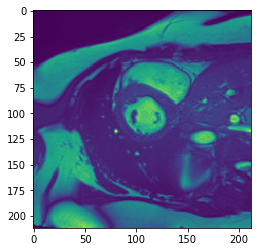

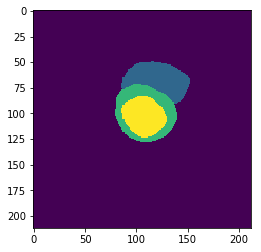

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_img[1])
plt.figure()
plt.imshow(train_label[1])

In [48]:
%matplotlib inline
from matplotlib import pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 10, 12

import json

import numpy as np

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage as ndi

import nibabel as nib

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers import Conv2D, Input
from keras.layers import Reshape, Dropout
from keras.layers import RepeatVector
from keras.layers import Activation, BatchNormalization
from keras.layers import concatenate, GlobalAveragePooling2D

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K

from ipywidgets import interact
import ipywidgets as widgets

K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [50]:
smooth_factor = 1.0

CROP_WIDTH = 200
CROP_HEIGHT = 200

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth_factor) / \
           (K.sum(y_true_f) + K.sum(y_pred_f) + smooth_factor)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def get_model():
    drop_rate_concat = 0.4
    drop_rate_hidden = 0.4
    bn_momentum = 0.1
    
    inputs = Input((CROP_HEIGHT, CROP_WIDTH, 1))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=bn_momentum)(conv1)
    conv1 = Dropout(drop_rate_hidden)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=bn_momentum)(conv1)
    conv1 = Dropout(drop_rate_hidden)(conv1)
    
    # Rate 2
    conv3 = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu',
                   padding='same', name="rate2_1")(conv1)
    conv3 = BatchNormalization(momentum=bn_momentum)(conv3)
    conv3 = Dropout(drop_rate_hidden)(conv3)
    conv3 = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu',
                   padding='same', name="rate2_2")(conv3)
    conv3 = BatchNormalization(momentum=bn_momentum)(conv3)
    conv3 = Dropout(drop_rate_hidden)(conv3)
    
    ############ Branches for ASPP
    
    # Branch for 1x1
    conv3a = Conv2D(32, (3, 3), activation='relu',
                    padding='same', name="branch1x1_1")(conv3)
    conv3a = BatchNormalization(momentum=bn_momentum)(conv3a)
    conv3a = Dropout(drop_rate_hidden)(conv3a)
    conv3a = Conv2D(32, (1, 1), activation='relu',
                    padding='same', name="branch1x1_2")(conv3a)
    conv3a = BatchNormalization(momentum=bn_momentum)(conv3a)
    conv3a = Dropout(drop_rate_hidden)(conv3a)
    
    # Branch for 3x3 rate 6
    conv4 = Conv2D(32, (3, 3), dilation_rate=(6, 6), activation='relu',
                   padding='same', name="rate6_1")(conv3)
    conv4 = BatchNormalization(momentum=bn_momentum)(conv4)
    conv4 = Dropout(drop_rate_hidden)(conv4)
    conv4 = Conv2D(32, (3, 3), dilation_rate=(6, 6), activation='relu',
                   padding='same', name="rate6_2")(conv4)
    conv4 = BatchNormalization(momentum=bn_momentum)(conv4)
    conv4 = Dropout(drop_rate_hidden)(conv4)
    
    # Branch for 3x3 rate 12
    conv5 = Conv2D(32, (3, 3), dilation_rate=(12, 12), activation='relu',
                   padding='same', name="rate12_1")(conv3)
    conv5 = BatchNormalization(momentum=bn_momentum)(conv5)
    conv5 = Dropout(drop_rate_hidden)(conv5)
    conv5 = Conv2D(32, (3, 3), dilation_rate=(12, 12), activation='relu',
                   padding='same', name="rate12_2")(conv5)
    conv5 = BatchNormalization(momentum=bn_momentum)(conv5)
    conv5 = Dropout(drop_rate_hidden)(conv5)
    
    # Branch for 3x3 rate 18
    conv6 = Conv2D(32, (3, 3), dilation_rate=(18, 18), activation='relu',
                   padding='same', name="rate18_1")(conv3)
    conv6 = BatchNormalization(momentum=bn_momentum)(conv6)
    conv6 = Dropout(drop_rate_hidden)(conv6)
    conv6 = Conv2D(32, (3, 3), dilation_rate=(18, 18), activation='relu',
                   padding='same', name="rate18_2")(conv6)
    conv6 = BatchNormalization(momentum=bn_momentum)(conv6)
    conv6 = Dropout(drop_rate_hidden)(conv6)
    
    # Branch for 3x3 rate 24
    conv7 = Conv2D(32, (3, 3), dilation_rate=(24, 24), activation='relu',
                   padding='same', name="rate24_1")(conv3)
    conv7 = BatchNormalization(momentum=bn_momentum)(conv7)
    conv7 = Dropout(drop_rate_hidden)(conv7)
    conv7 = Conv2D(32, (3, 3), dilation_rate=(24, 24), activation='relu',
                   padding='same', name="rate24_2")(conv7)
    conv7 = BatchNormalization(momentum=bn_momentum)(conv7)
    conv7 = Dropout(drop_rate_hidden)(conv7)
    
    # Branch for the global context
    global_pool = GlobalAveragePooling2D()(conv1)
    global_pool = RepeatVector(CROP_HEIGHT*CROP_WIDTH)(global_pool)
    global_pool = Reshape((CROP_HEIGHT, CROP_WIDTH, 32))(global_pool)
    
    ############# Concatenation 
    concat = concatenate([conv3a, conv4, conv5,
                          conv6, global_pool, conv7], axis=3)
    concat = BatchNormalization(momentum=bn_momentum)(concat)
    concat = Dropout(drop_rate_concat)(concat)
    
    amort = Conv2D(64, (1, 1), activation='relu',
                   padding='same', name="amort")(concat)
    amort = BatchNormalization(momentum=bn_momentum)(amort)
    amort = Dropout(drop_rate_hidden)(amort)

    predictions = Conv2D(1, (1, 1), activation='sigmoid',
                         padding='same', name="predictions")(amort)

    model = Model(inputs=[inputs], outputs=[predictions])
    return model

model = get_model()
opt = Adam(lr=0.001)

model.compile(optimizer=opt,
              loss=dice_coef_loss,
              metrics=["accuracy"])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200, 200, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 200, 200, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 200, 200, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 200, 200, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [ ]:
model.fit()